In [253]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

In [254]:
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")

In [255]:
data = pd.merge(transactions, customers, on="CustomerID",how= 'left')

In [256]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [257]:
agg_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Price': 'mean'
}).rename(columns={
    'TotalValue': 'TotalPurchase',
    'TransactionID': 'TransactionCount',
    'Price': 'AvgTransactionValue'
})

In [258]:
agg_data.head()

,TotalPurchase,TransactionCount,AvgTransactionValue
CustomerID,,,
C0001,3354.52,5,278.334000
C0002,1862.74,4,208.920000
C0003,2725.38,4,195.707500
C0004,5354.88,8,240.636250
C0005,2034.24,3,291.603333


In [259]:
agg_data = pd.merge(agg_data, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

In [260]:
agg_data.head()

,CustomerID,TotalPurchase,TransactionCount,AvgTransactionValue,Region
0,C0001,3354.52,5,278.334000,South America
1,C0002,1862.74,4,208.920000,Asia
2,C0003,2725.38,4,195.707500,South America
3,C0004,5354.88,8,240.636250,South America
4,C0005,2034.24,3,291.603333,Asia


In [261]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [262]:
region_encoded = encoder.fit_transform(agg_data[['Region']])


In [263]:
region_columns = encoder.get_feature_names_out(['Region'])
region_df = pd.DataFrame(region_encoded, columns=region_columns, index=agg_data.index)


In [264]:
agg_data = pd.concat([agg_data.drop(columns=['Region']), region_df], axis=1)

In [265]:
agg_data.head()

,CustomerID,TotalPurchase,TransactionCount,AvgTransactionValue,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,5,278.334000,0.0,0.0,0.0,1.0
1,C0002,1862.74,4,208.920000,1.0,0.0,0.0,0.0
2,C0003,2725.38,4,195.707500,0.0,0.0,0.0,1.0
3,C0004,5354.88,8,240.636250,0.0,0.0,0.0,1.0
4,C0005,2034.24,3,291.603333,1.0,0.0,0.0,0.0


In [268]:
cluster_data = agg_data.drop(columns=['CustomerID'])

In [269]:
sse = []  # Sum of Squared Errors
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data)
    sse.append(kmeans.inertia_)

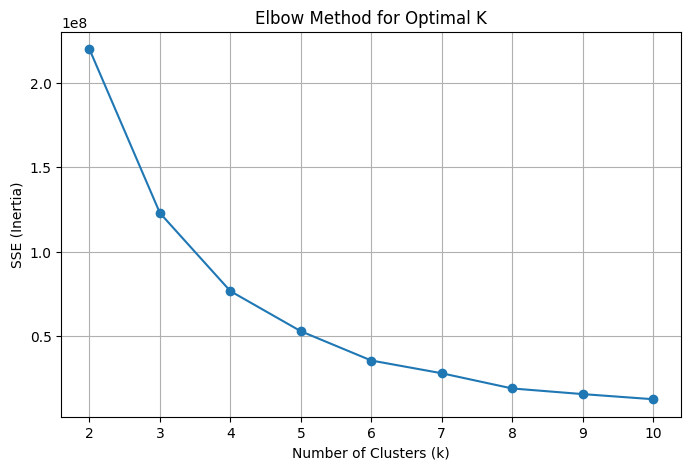

In [270]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.grid()
plt.show()


In [271]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(cluster_data)

In [272]:
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(cluster_data)

In [273]:
kmeans_db_index = davies_bouldin_score(cluster_data, kmeans_labels)
hierarchical_db_index = davies_bouldin_score(cluster_data, hierarchical_labels)

In [274]:
kmeans_db_index = davies_bouldin_score(cluster_data, kmeans_labels)
kmeans_silhouette = silhouette_score(cluster_data, kmeans_labels)
print(f"K-Means DB Index: {kmeans_db_index}")
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

K-Means DB Index: 0.5375340113528055
K-Means Silhouette Score: 0.5220966404236095


In [275]:
hierarchical_db_index = davies_bouldin_score(cluster_data, hierarchical_labels)
hierarchical_silhouette = silhouette_score(cluster_data, hierarchical_labels)
print(f"Hierarchical Clustering DB Index: {hierarchical_db_index}")
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette}")

Hierarchical Clustering DB Index: 0.535822698369692
Hierarchical Clustering Silhouette Score: 0.5266720067937255


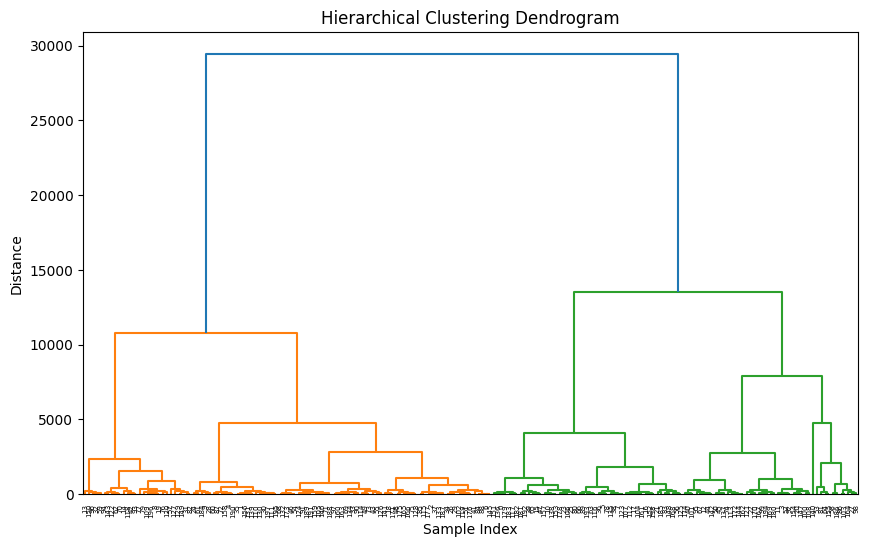

In [276]:
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(cluster_data, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [277]:
from sklearn.decomposition import PCA

In [278]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_data)

In [279]:
agg_data['PCA1'] = pca_result[:, 0]
agg_data['PCA2'] = pca_result[:, 1]
agg_data['KMeans_Cluster'] = kmeans_labels
agg_data['Hierarchical_Cluster'] = hierarchical_labels

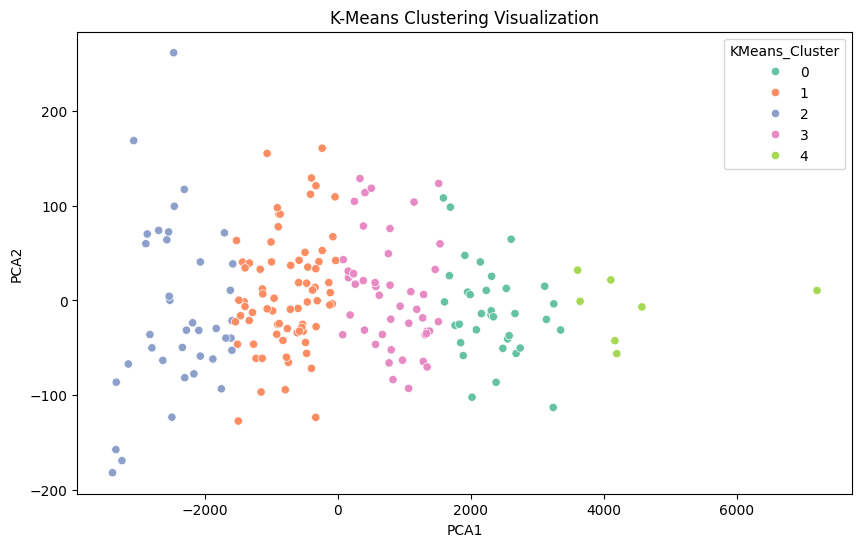

In [280]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=agg_data, palette='Set2')
plt.title('K-Means Clustering Visualization')
plt.show()

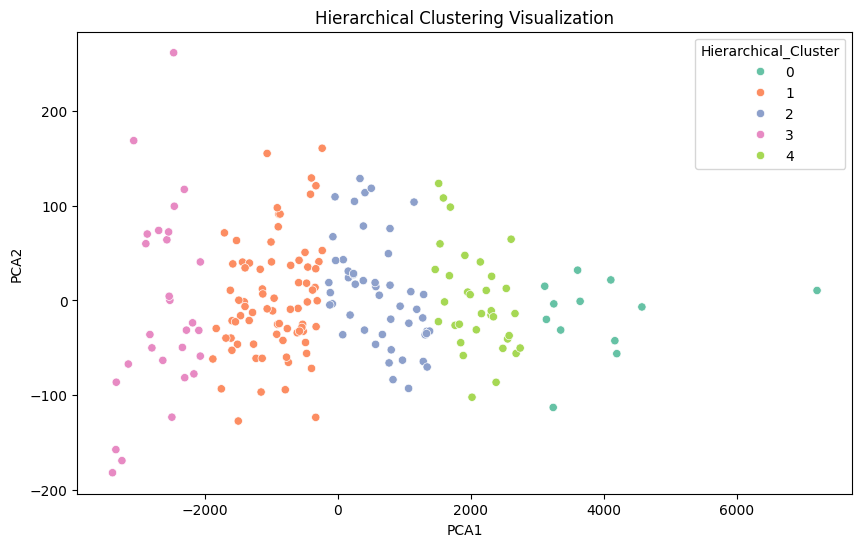

In [281]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Hierarchical_Cluster', data=agg_data, palette='Set2')
plt.title('Hierarchical Clustering Visualization')
plt.show()